#### Objective

With this workflow I import an image with a map, isolate the map using morphological operations, then reduce the number of colours with segmentation. The resulting image is the input to a colormap recognition and data extration workflow.

#### Preliminaries - import main libraries

In [1]:
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import segmentation, color, io
from skimage.color import rgb2gray 

from skimage.morphology import disk, square, closing, opening, erosion, dilation
from skimage.morphology import reconstruction, remove_small_objects, remove_small_holes

%matplotlib inline

#### Import test image

In [2]:
#url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test1.png'
#url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test2.png'
#url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test_with_text.png'
url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test_seismic.png'

img = np.asarray(io.imread(url))[:,:,:3] # removing alpha channel

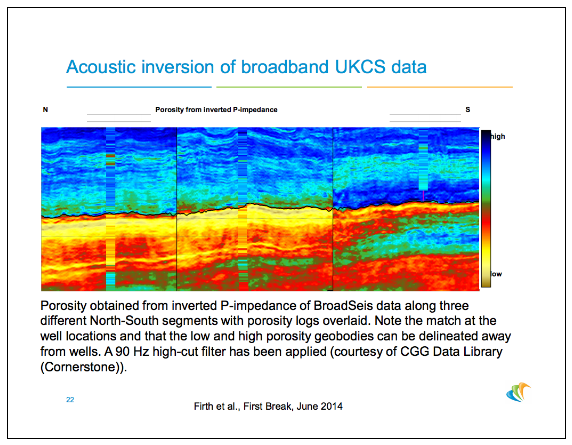

In [3]:
# Plot image
# from CGG's website: http://www.cgg.asia/default.aspx?cid=4-8831-9993-2124-9740-9744
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
plt.imshow(img)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

#### Find the map

We want to eliminate both possibilities of ~black and ~nearly white border

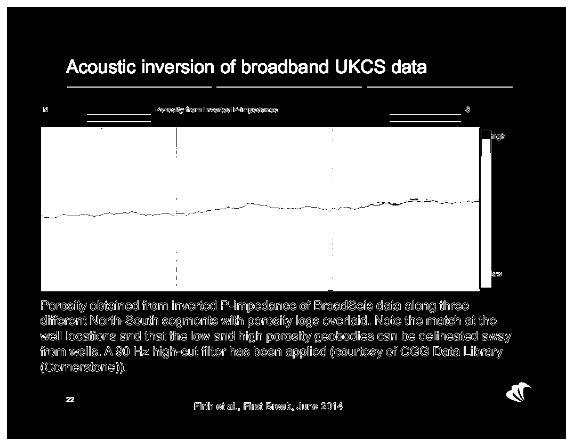

In [4]:
binary = np.logical_and(color.rgb2gray(img) > 0.03, color.rgb2gray(img) < 0.97)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Get largest element in ghe binary image and use it as a mask for the original image

Detect largest bright element in the binary image. Making the assumption it would be the map.
Eliminate everything else (text, colorbar, holes, etc.).

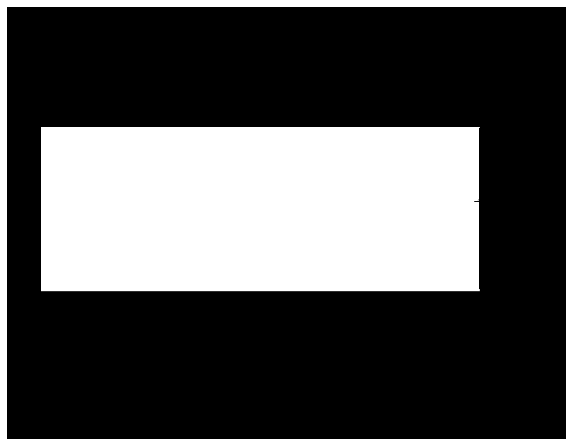

In [5]:
# Label all white objects (made up of ones)
label_objects, nb_labels = ndi.label(binary) # ndimage.label labels 0 (background) as 0 and then labels every nonzero
                                                    # object as 1, 2, ... n. 
    
# Calculate every labeled object's size. np.bincount ignores whether input is an image or another type of array.
# It just calculates the binary sizes, including for the 0 (background).
sizes = np.bincount(label_objects.ravel())   
sizes[0] = 0    # This sets the size of the background to 0 so that if it happened to be larger than the larges bright
                # object it would not matter

# Keep only largest object
binary_objects = remove_small_objects(binary, max(sizes)) 

# Remove holes from it
binary_holes = remove_small_holes(binary_objects, max(sizes)) 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_holes, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

In the step above, which filled holes in the map, we used 'remove_small_holes'. Because this operation removes continguous holes smaller than the specified size, if we specify the size of the object itself, all holes will be removed. 

Another alternative to remove all holes without using 'closing' with a hardcoded structuring element size would be to use a while-loop and the Euler number of the binary image with just one object (euler number is returned by 'regionprops'). The Euler number of this image would be 1, minus the number of holes. So at each iteration the Euler number would be checked and if it wasn't one, then dilation would be run, at each iteration with structuring element size increased by 1, until the Euler number did become 1.

There is also 'filled_image' returned by 'regionprops', which is the binary region image with filled holes which has the same size as bounding box. However, if there are tick marks outside this would be including them.

#### Optionally remove outside tick marks

Could add an erision step to remove outside tick marks. To avoid hard coding the structuring element size I could use the median of the differences in lenghts between pairs of consecutive rows and/or columns in the binary with filled holes).

In [6]:
# Convert cleaned binary image to a 3D array mask to use in next cell

mask3 = np.zeros(img.shape)
mask3[:,:,0] = binary_holes
mask3[:,:,1] = binary_holes
mask3[:,:,2] = binary_holes

In [7]:
# Use the mask to get only the map in the original image
final = np.ma.masked_where(mask3 ==0, img)
final = final.filled(0)

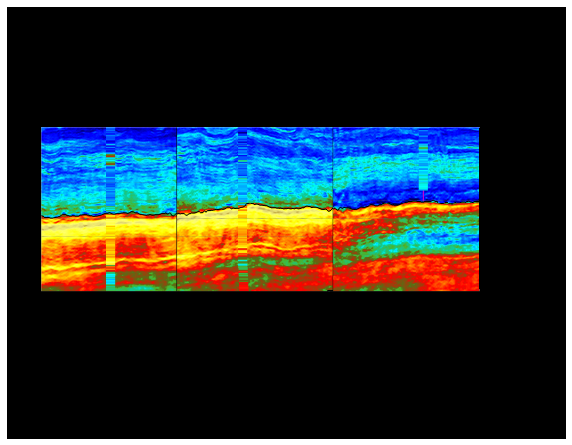

In [8]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(final)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Crop zero columns and zero rows

http://stackoverflow.com/a/14211727/1034648

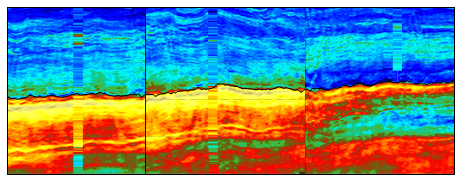

In [9]:
non_empty_columns = np.where(final.max(axis=0)>0)[0]
non_empty_rows = np.where(final.max(axis=1)>0)[0]
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

final_crop = final[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(final_crop, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

N.B. The workflow seems to work even when the map touches the border, as in:
https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebook/test2.png

#### Reduce number of colours

I use here Scikit-learn segmentation using k-means clustering in Color-(x,y,z) space:
http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

In [10]:
labels1 = segmentation.slic(final_crop, compactness=30, n_segments=1024, convert2lab = 'True') 
out1 = color.label2rgb(labels1, final_crop, kind='avg')

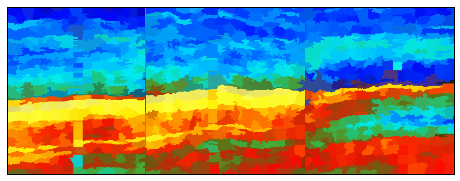

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(out1)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()